In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "30"

import sys
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert

import statsmodels

import complex_inversion_tools as cit

import matplotlib.transforms as mtransforms

(<AxesSubplot:>, None)

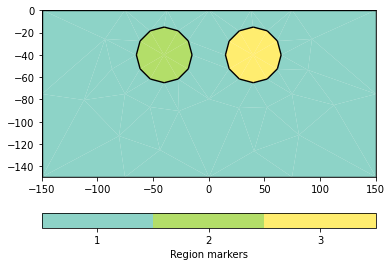

In [2]:
# creating the geometry to simulate the synthetic measurements

world = mt.createWorld(start=(-150, 0), end=(150, -150), marker=1)
circle = mt.createCircle(pos=(-40, -40), radius=25, marker=2, boundaryMarker=-1)
circle2 = mt.createCircle(pos=(40, -40), radius=25, marker=3, boundaryMarker=-1)
geom = world + circle + circle2

pg.show(geom)

In [3]:
# creating the measurements scheme

elecs = np.linspace(-100, 100, 50)
scheme = ert.createERTData(elecs, schemeName="dd")

In [4]:
# defining the complex resistivities of the subsurface model

rhomap = [
    [1, np.exp(2 - 20j / 1000)],
    [2, np.exp(1 - 15j / 1000)],
    [3, np.exp(3 - 60j / 1000)]
]

In [5]:
for s in scheme.sensors():
    geom.createNode(s)
    world.createNode(s)

INFO:pyGIMLi:Cache /home/hase/anaconda3/envs/pygimli2/lib/python3.7/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (10.3s x 318): /home/hase/.cache/pygimli/10188863217491563582


/home/hase/anaconda3/envs/pygimli2/lib/python3.7/site-packages/pygimli/viewer/mpl/colorbar.py:434: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  mappable.get_cmap().set_bad([1.0, 1.0, 1.0, 0.0])
27/02/24 - 14:37:16 - pyGIMLi - INFO - Cache /home/hase/anaconda3/envs/pygimli2/lib/python3.7/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (10.3s x 318): /home/hase/.cache/pygimli/10188863217491563582


INFO:pyGIMLi:Cache /home/hase/anaconda3/envs/pygimli2/lib/python3.7/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (10.3s x 319): /home/hase/.cache/pygimli/10188863217491563582


27/02/24 - 14:37:16 - pyGIMLi - INFO - Cache /home/hase/anaconda3/envs/pygimli2/lib/python3.7/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (10.3s x 319): /home/hase/.cache/pygimli/10188863217491563582


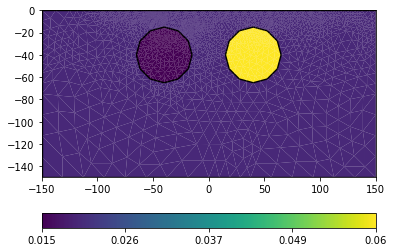

In [6]:
# creating the mesh used for the simulation of the synthetic data

mesh_fwd = pg.meshtools.createMesh(geom, quality=34.5).createH2()
true_conductivity = np.log(1 / pg.solver.parseMapToCellArray(rhomap, mesh_fwd))
pg.show(mesh_fwd, true_conductivity.imag)

geom_factors = ert.createGeometricFactors(scheme, mesh=mesh_fwd)

scheme.add("k", ert.createGeometricFactors(scheme, mesh=mesh_fwd))

In [7]:
geom_factors = np.array(geom_factors)

In [8]:
# simulating the synthetic measurements

ERT = pg.physics.ert.ERTManager(verbose=True, sr=0)
ERT.fop.setComplex(True)
data = ERT.simulate(mesh_fwd, scheme=scheme, res=rhomap, noiseLevel=0.0)

INFO:pyGIMLi:Complex resistivity values found.


27/02/24 - 14:37:16 - pyGIMLi - INFO - Complex resistivity values found.


(<AxesSubplot:>, None)

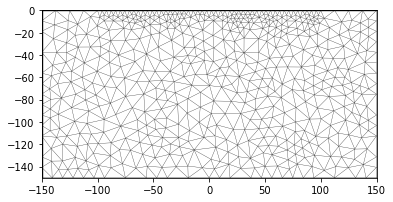

In [9]:
# creating a second mesh for the inversion to avoid inverse crimes

mesh_inv_inner = pg.meshtools.createMesh(world, quality=34.5, area=100)
pg.show(mesh_inv_inner, markers=False)

(<AxesSubplot:>, None)

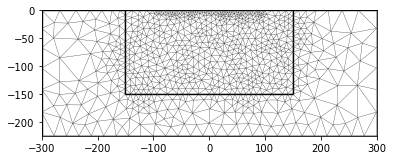

In [10]:
mesh_inv = pg.meshtools.appendTriangleBoundary(mesh_inv_inner, marker=0)
pg.show(mesh_inv, markers=False)

In [11]:
# setting up the forward operator for the inversion

ERTinv = pg.physics.ert.ERTManager(data=data)
ERTinv.applyMesh(mesh_inv)

<class 'pygimli.physics.ert.ert.ERTManager'>.applyMesh(methodManager.py:647) : Mesh: Nodes: 812 Cells: 1512 Boundaries: 2323
INFO:pyGIMLi:Found 2 regions.


27/02/24 - 14:37:18 - pyGIMLi - INFO - Found 2 regions.


INFO:pyGIMLi:Region with smallest marker set to background (marker=0)


27/02/24 - 14:37:18 - pyGIMLi - INFO - Region with smallest marker set to background (marker=0)


In [12]:
# setting up the forward operator for the inversion

fop = pg.physics.ert.ERTModelling(sr=0, verbose=True)
fop.setComplex(True)
fop.setData(data)
fop.setMesh(ERTinv.paraDomain, ignoreRegionManager=True)

# defining dimensions of model and data space
M = ERTinv.paraDomain.cellCount()
D = len(data["rhoa"])

INFO:pyGIMLi:Creating forward mesh from region infos.


27/02/24 - 14:37:18 - pyGIMLi - INFO - Creating forward mesh from region infos.


27/02/24 - 14:37:18 - Core - WARNING - Region Nr: 0  is background and should not get a model transformation.


27/02/24 - 14:37:18 - Core - WARNING - Region Nr: 0  is background and should not get a model control.


INFO:pyGIMLi:Creating refined mesh (H2) to solve forward task.


27/02/24 - 14:37:18 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


In [13]:
# setting up the regularization operator(s)

rm = fop.regionManager()
rm.setVerbose(True)
rm.setConstraintType(2)

Wm = pg.matrix.SparseMapMatrix()
rm.fillConstraints(Wm)
Wm = pg.utils.sparseMatrix2coo(Wm)

C_M_inv = (Wm.T @ Wm).toarray()

INFO:Core:More than 50 regions so we assume singles only regions.


27/02/24 - 14:37:18 - Core - INFO - More than 50 regions so we assume singles only regions.


INFO:Core:Applying *:* interregion constraints.


27/02/24 - 14:37:18 - Core - INFO - Applying *:* interregion constraints.


In [14]:
rhoa_complex = pg.utils.toComplex(data["rhoa"], data["phia"])
log_measurements = np.log(rhoa_complex**-1)

Z_complex = np.exp(-log_measurements) / geom_factors

In [15]:
# definition of the error models for impedance magnitude and phase

def error_model_lnmag(x, a, b):
    
    lin = np.abs(x) * a + b
    
    return lin / np.abs(x)

def error_model_phase(x, a, b, c):
    return a * np.abs(x) ** b + c

In [16]:
# synthetic noise

np.random.seed(42)

std_real = error_model_lnmag(np.abs(Z_complex), 1e-1, 1e-6)
std_imag = error_model_phase(np.abs(Z_complex), 1e-7, -0.9, 1e-4)

noise_real = - np.random.normal(loc=0, scale=std_real) / np.abs(rhoa_complex)
noise_imag = np.random.normal(loc=0, scale=std_imag)
noise_complex = noise_real + 1j * noise_imag
log_measurements = log_measurements + noise_complex

/home/hase/anaconda3/envs/pygimli2/lib/python3.7/site-packages/pygimli/viewer/mpl/colorbar.py:434: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  mappable.get_cmap().set_bad([1.0, 1.0, 1.0, 0.0])


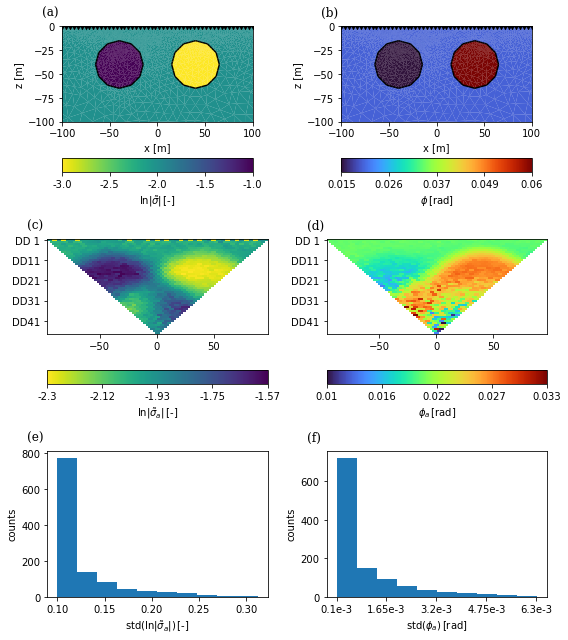

In [17]:
electrode_positions = np.array(scheme.sensorPositions())[:, 0:2]

fig, axes = plt.subplot_mosaic([["(a)", "(b)"], ["(c)", "(d)"], ["(e)", "(f)"]], figsize=(8, 9))

ax = axes["(a)"]
ax.set_title(" ")
pg.show(mesh_fwd, true_conductivity.real, ax=ax, label=r"$\ln|\tilde{\sigma}|\,$[-]", logScale=0, cMap="viridis_r", showBoundary=True)

ax = axes["(b)"]
pg.show(mesh_fwd, (true_conductivity).imag, ax=ax, label=r"$\phi\,$[rad]", logScale=0, cMap="turbo", showBoundary=True)

for iax in ["(a)", "(b)"]:
    ax = axes[iax]
    ax.scatter(electrode_positions[:, 0], electrode_positions[:, 1], marker="v", color="k")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("z [m]")
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 0)
    
    label = iax
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize='large', va='bottom', fontfamily='serif')

ax = axes["(c)"]
ax.set_title(" ")
ert.showERTData(data, log_measurements.real, ax=ax, label=r"$\ln|\tilde{\sigma}_a|\,$[-]", cMap="viridis_r", logScale=False)

ax = axes["(d)"]
ax.set_title(" ")
ert.showERTData(data, log_measurements.imag, ax=ax, label=r"$\phi_a\,$[rad]", cMap="turbo", logScale=False)

ax = axes["(e)"]
ax.set_title(" ")
ax.set_ylabel("counts")
ax.set_xlabel(r"std$(\ln|\tilde{\sigma}_a|)\,$[-]")
ax.hist(std_real)

ax = axes["(f)"]
ax.set_title(" ")
ax.set_ylabel("counts")
ax.set_xlabel(r"std$(\phi_a)\,$[rad]")
ax.hist(std_imag)
ax.set_xticks(np.linspace(np.round(np.min(std_imag), 4), np.round(np.max(std_imag), 4), 5))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.xaxis.set_major_formatter(lambda x, pos: str(np.round(x, 5) * 1e3) + "e-3") 

for iax in ["(c)", "(d)", "(e)", "(f)"]:
    
    ax = axes[iax]
    
    label = iax
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize='large', va='bottom', fontfamily='serif')

fig.tight_layout()

# fig.savefig("Figure1.pdf", bbox_inches="tight")

In [18]:
# Inversion using the full capabilities of the probabilistic framework

m = np.ones(2 * M) * (-1 + 1e-2j)
m[M:] = m[:M].conj()

mp = np.zeros_like(m)

d = np.hstack([log_measurements, log_measurements.conj()]).flatten()

def solve_forward_problem(m):
    
    rho = np.exp(-m[:M])

    response = pg.utils.toComplex(np.array(
        fop.response(np.array(pg.utils.squeezeComplex(rho)))))
    response = np.log(response**-1)
    
    J = fop.createJacobian(pg.utils.squeezeComplex(rho))
    J = np.array(J.mat(0)) + 1j * np.array(J.mat(1))
    J = np.multiply(J.T, -response**-2).T
    J = np.multiply(J, - rho)
    
    return np.hstack([response, response.conj()]).flatten(), J
    

# definition of the data covariance matrix with independent error estimates for impedance magnitude and phase
V_Re = np.diag(std_real ** 2)
V_Im = np.diag(std_imag ** 2)

Rd = np.vstack((
    np.hstack((V_Re + V_Im, V_Re - V_Im)),
    np.hstack(((V_Re - V_Im).conj().T, (V_Re + V_Im).conj()))
))
Rd = np.linalg.inv(Rd)

# definition of the inverse prior covariance matrix, using regularization
#     operators that are independently scaled with alpha, beta (corresponding to lamda_real, lambda_imag in the paper)
alpha = np.exp(6.3)
beta = np.exp(11)

VM_on = C_M_inv * (alpha + beta)
VM_off = C_M_inv * (alpha - beta)

Rm = np.vstack((
    np.hstack((VM_on, VM_off)),
    np.hstack((VM_off.conj().T, VM_on))
))

# for inversion details look at the definition of the Complex_Inversion_Manager in library.py
ciManager = cit.Complex_Inversion_Manager(m, d, solve_forward_problem, 1, Rd, Rm, mp)
ciManager.invVr = np.linalg.inv(V_Re)
ciManager.invVi = np.linalg.inv(V_Im)

ciManager.inversion(N_iterations=30, perform_line_search=0, ignore_cost_increase=1)

m_plot = ciManager.m[:M]

# using final model to calculate covariance
rmse = ciManager.rmse(ciManager.d, ciManager.solve_forward_problem(ciManager.m)[0])
COV = np.linalg.inv(ciManager.Jc.conj().T @ ciManager.Rd @ ciManager.Jc + ciManager.lam * ciManager.Rm)

INFO:pyGIMLi:Creating forward mesh from region infos.


27/02/24 - 14:37:22 - pyGIMLi - INFO - Creating forward mesh from region infos.


INFO:pyGIMLi:Creating refined mesh (H2) to solve forward task.


27/02/24 - 14:37:22 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


39.356783573843266 9.100151646812128 54.909926848973434
INFO:root:
####################
Main iteration 0
####################


27/02/24 - 14:37:26 - root - INFO - 
####################
Main iteration 0
####################


rmse  (39.356783573843266, 9.100151646812128, 54.909926848973434)
INFO:root:
####################
Main iteration 1
####################


27/02/24 - 14:37:31 - root - INFO - 
####################
Main iteration 1
####################


rmse  (12.922401039486429, 6.091670840937646, 17.229870679034736)
INFO:root:
####################
Main iteration 2
####################


27/02/24 - 14:37:36 - root - INFO - 
####################
Main iteration 2
####################


rmse  (3.7371346152957035, 3.616090971134616, 3.854378854514255)
INFO:root:
####################
Main iteration 3
####################


27/02/24 - 14:37:41 - root - INFO - 
####################
Main iteration 3
####################


rmse  (4.5736830899221035, 2.1126859719069824, 6.113404288784572)
INFO:root:
####################
Main iteration 4
####################


27/02/24 - 14:37:46 - root - INFO - 
####################
Main iteration 4
####################


rmse  (3.1952453044595757, 1.3863446998586146, 4.300841020602698)
INFO:root:
####################
Main iteration 5
####################


27/02/24 - 14:37:51 - root - INFO - 
####################
Main iteration 5
####################


rmse  (1.9486471622025783, 1.1167688980100983, 2.5193806290347847)
INFO:root:
####################
Main iteration 6
####################


27/02/24 - 14:37:57 - root - INFO - 
####################
Main iteration 6
####################


rmse  (1.307994896646579, 1.0390425172167306, 1.5303894755004326)
INFO:root:
####################
Main iteration 7
####################


27/02/24 - 14:38:01 - root - INFO - 
####################
Main iteration 7
####################


rmse  (1.0755704790033305, 1.0198007638693654, 1.1285876627984348)
INFO:root:
####################
Main iteration 8
####################


27/02/24 - 14:38:07 - root - INFO - 
####################
Main iteration 8
####################


rmse  (1.0096479744444478, 1.015453711279341, 1.0038086594818232)
INFO:root:Final rmse: (1.0096479744444478, 1.015453711279341, 1.0038086594818232)


27/02/24 - 14:38:16 - root - INFO - Final rmse: (1.0096479744444478, 1.015453711279341, 1.0038086594818232)


In [19]:
# Inversion using the WLSQ framework

m = np.ones(2 * M) * (-1 + 1e-2j)
m[M:] = m[:M].conj()

mp = np.zeros_like(m)

d = np.hstack([log_measurements, log_measurements.conj()]).flatten()


def solve_forward_problem(m):
    
    rho = np.exp(-m[:M])

    response = pg.utils.toComplex(np.array(
        fop.response(np.array(pg.utils.squeezeComplex(rho)))))
    response = np.log(response**-1)
    
    J = fop.createJacobian(pg.utils.squeezeComplex(rho))
    J = np.array(J.mat(0)) + 1j * np.array(J.mat(1))
    J = np.multiply(J.T, -response**-2).T
    J = np.multiply(J, - rho)
    
    return np.hstack([response, response.conj()]).flatten(), J
    
# definition of the data covariance matrix assuming equal error estimates for impedance magnitude and phase
V_Re = np.diag(std_real ** 2)
V_Im = np.diag(std_imag ** 2)

Rd = np.vstack((
    np.hstack((V_Re + V_Im, np.zeros_like(V_Re - V_Im))),
    np.hstack((np.zeros_like(V_Re - V_Im).conj().T, (V_Re + V_Im).conj()))
))
Rd = np.linalg.inv(Rd)

# definition of the inverse prior covariance matrix, using regularization applied equally to conductivity magnitude and phase
alpha = np.exp(7)
beta = alpha

VM_on = C_M_inv * (alpha + beta)
VM_off = C_M_inv * (alpha - beta)

Rm = np.vstack((
    np.hstack((VM_on, VM_off)),
    np.hstack((VM_off.conj().T, VM_on))
))


ciManager = cit.Complex_Inversion_Manager(m, d, solve_forward_problem, 1, Rd, Rm, mp)
ciManager.invVr = np.linalg.inv(V_Re)
ciManager.invVi = np.linalg.inv(V_Im)

ciManager.inversion(N_iterations=30, perform_line_search=0, ignore_cost_increase=1)

m_plot2 = ciManager.m[:M]
rmse2 = ciManager.rmse(ciManager.d, ciManager.solve_forward_problem(ciManager.m)[0])
COV2 = np.linalg.inv(ciManager.Jc.conj().T @ ciManager.Rd @ ciManager.Jc + ciManager.lam * ciManager.Rm)

9.100603411078605 9.100151646812128 54.909926848973434
INFO:root:
####################
Main iteration 0
####################


27/02/24 - 14:38:26 - root - INFO - 
####################
Main iteration 0
####################


rmse  (9.100603411078605, 9.100151646812128, 54.909926848973434)
INFO:root:
####################
Main iteration 1
####################


27/02/24 - 14:38:35 - root - INFO - 
####################
Main iteration 1
####################


rmse  (5.9954514325619845, 5.995462911599227, 15.746517394446235)
INFO:root:
####################
Main iteration 2
####################


27/02/24 - 14:38:50 - root - INFO - 
####################
Main iteration 2
####################


rmse  (3.3552522493163823, 3.355294866834622, 8.191177607568248)
INFO:root:
####################
Main iteration 3
####################


27/02/24 - 14:39:01 - root - INFO - 
####################
Main iteration 3
####################


rmse  (1.8456685097322316, 1.8456083027619605, 10.340007365325517)
INFO:root:
####################
Main iteration 4
####################


27/02/24 - 14:39:15 - root - INFO - 
####################
Main iteration 4
####################


rmse  (1.2370379640845632, 1.2369433792208666, 8.933323758491445)
INFO:root:
####################
Main iteration 5
####################


27/02/24 - 14:39:26 - root - INFO - 
####################
Main iteration 5
####################


rmse  (1.0597523431335616, 1.0596479207307663, 7.971158632024342)
INFO:root:
####################
Main iteration 6
####################


27/02/24 - 14:39:41 - root - INFO - 
####################
Main iteration 6
####################


rmse  (1.018357133401127, 1.0182481292438834, 7.583471148924339)
INFO:root:
####################
Main iteration 7
####################


27/02/24 - 14:39:50 - root - INFO - 
####################
Main iteration 7
####################


rmse  (1.0094888890031113, 1.0093774751437978, 7.451640729484661)
INFO:root:Final rmse: (1.0094888890031113, 1.0093774751437978, 7.451640729484661)


27/02/24 - 14:40:02 - root - INFO - Final rmse: (1.0094888890031113, 1.0093774751437978, 7.451640729484661)


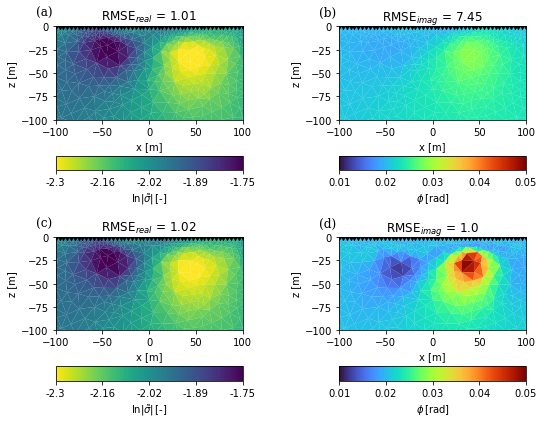

In [20]:
fig, axes = plt.subplot_mosaic([["(a)", "(b)"], ["(c)", "(d)"]], figsize=(8, 6))

ax = axes["(c)"]
ax.set_title(r"RMSE$_{real}$ = " + str(np.round(rmse[1], 2)))
pg.show(ERTinv.paraDomain, (np.real(m_plot)), ax=ax, label=r"$\ln|\tilde{\sigma}|\,$[-]", logScale=0, cMap="viridis_r", cMin=-2.3, cMax=-1.75)

ax = axes["(d)"]
ax.set_title(r"RMSE$_{imag}$ = " + str(np.round(rmse[2], 2)))
pg.show(ERTinv.paraDomain, np.imag(m_plot), ax=ax, label=r"$\phi\,$[rad]", logScale=0, cMap="turbo", cMin=0.01, cMax=0.05)

ax = axes["(a)"]
ax.set_title(r"RMSE$_{real}$ = " + str(np.round(rmse2[1], 2)))
pg.show(ERTinv.paraDomain, (np.real(m_plot2)), ax=ax, label=r"$\ln|\tilde{\sigma}|\,$[-]", logScale=0, cMap="viridis_r", cMin=-2.3, cMax=-1.75)

ax = axes["(b)"]
ax.set_title(r"RMSE$_{imag}$ = " + str(np.round(rmse2[2], 2)))
pg.show(ERTinv.paraDomain, np.imag(m_plot2), ax=ax, label=r"$\phi\,$[rad]", logScale=0, cMap="turbo", cMin=0.01, cMax=0.05)

for iax in axes.keys():
    ax = axes[iax]
    ax.scatter(electrode_positions[:, 0], electrode_positions[:, 1], marker="v", color="k")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("z [m]")
    
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 0)
    
    label = iax
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize='large', va='bottom', fontfamily='serif')

fig.tight_layout()

# fig.savefig("Figure2.pdf", bbox_inches="tight")

In [21]:
# estimation of the variances

Vxx = np.diagonal(ciManager._S_inv @ COV @ ciManager._S)[:ciManager.M].real * 0.5
Vyy = np.diagonal(ciManager._S_inv @ COV @ ciManager._S)[ciManager.M:].real * 0.5

Vxx2 = np.diagonal(ciManager._S_inv @ COV2 @ ciManager._S)[:ciManager.M].real * 0.5
Vyy2 = np.diagonal(ciManager._S_inv @ COV2 @ ciManager._S)[ciManager.M:].real * 0.5

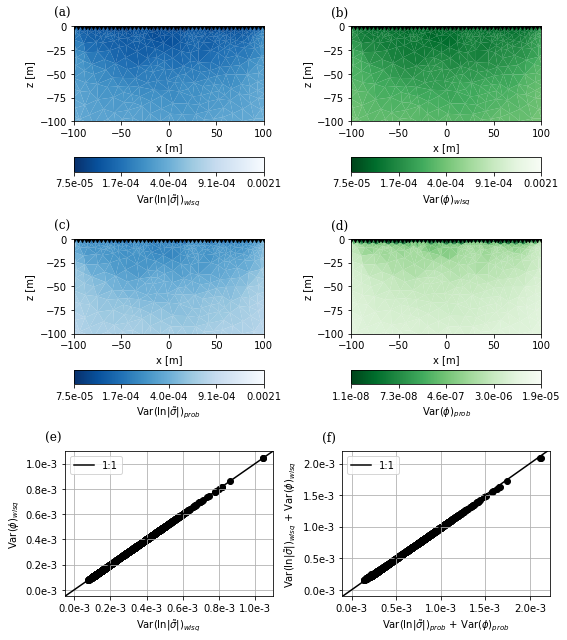

In [22]:
fig, axes = plt.subplot_mosaic([["(a)", "(b)"], ["(c)", "(d)"], ["(e)", "(f)"]], figsize=(8, 9))

ax = axes["(c)"]
pg.show(mesh_inv_inner, Vxx, logScale=1, cMap="Blues_r", ax=ax, label=r"Var$(\ln|\tilde{\sigma}|)_{prob}$", cMin=7.5e-5, cMax=0.0021)

ax = axes["(d)"]
pg.show(mesh_inv_inner, Vyy, logScale=1, cMap="Greens_r", ax=ax, label=r"Var$(\phi)_{prob}$")


ax = axes["(a)"]
pg.show(mesh_inv_inner, Vxx2, logScale=1, cMap="Blues_r", ax=ax, label=r"Var$(\ln|\tilde{\sigma}|)_{wlsq}$", cMin=7.5e-5, cMax=0.0021)


ax = axes["(b)"]
pg.show(mesh_inv_inner, Vyy2, logScale=1, cMap="Greens_r", ax=ax, label=r"Var$(\phi)_{wlsq}$", cMin=7.5e-5, cMax=0.0021)


ax = axes["(e)"]
ax.scatter(Vxx2 * 1e3, Vyy2 * 1e3, color="k")
ax.grid()
ax.axline((0, 0), slope=1, ls="-", color="k", label="1:1")
ax.set_xlabel(r"Var($\ln|\tilde{\sigma}|$)$_{wlsq}$")
ax.set_ylabel(r"Var($\phi$)$_{wlsq}$")
ax.legend(loc=0)
ax.xaxis.set_major_formatter(lambda x, pos: str(np.round(x, 2)) + "e-3") 
ax.yaxis.set_major_formatter(lambda x, pos: str(np.round(x, 2)) + "e-3") 

ax = axes["(f)"]
ax.scatter((Vxx + Vyy) * 1e3, (Vxx2 + Vyy2) * 1e3, color="k")
ax.grid()
ax.axline((0, 0), slope=1, ls="-", color="k", label="1:1")
ax.set_xlabel(r"Var($\ln|\tilde{\sigma}|$)$_{prob}$ + Var($\phi$)$_{prob}$")
ax.set_ylabel(r"Var($\ln|\tilde{\sigma}|$)$_{wlsq}$ + Var($\phi$)$_{wlsq}$")
ax.legend(loc=0)
ax.xaxis.set_major_formatter(lambda x, pos: str(np.round(x, 2)) + "e-3") 
ax.yaxis.set_major_formatter(lambda x, pos: str(np.round(x, 2)) + "e-3") 

for iax in axes.keys():
        
    ax = axes[iax]
    
    if iax not in ("(e)", "(f)"):
    
        ax.scatter(electrode_positions[:, 0], electrode_positions[:, 1], marker="v", color="k")
        ax.set_xlabel("x [m]")
        ax.set_ylabel("z [m]")

        ax.set_xlim(-100, 100)
        ax.set_ylim(-100, 0)
    
    label = iax
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize='large', va='bottom', fontfamily='serif')
    ax.set_title(" ")

fig.tight_layout()

# fig.savefig("Figure3.pdf", bbox_inches="tight")